### Computing whether our transistor circuit minimizes power at free state

In [1]:
%reload_ext autoreload
%autoreload 2

from PySpice.Spice.Netlist import Circuit, SubCircuit
from PySpice.Spice.Parser import SpiceParser
from PySpice.Probe.WaveForm import WaveForm
from PySpice.Unit import *
import PySpice
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import ltspice
import os

In [2]:
# setup logging 
from PySpice.Logging import Logging
logger = Logging.setup_logging(logging_level='DEBUG')

In [3]:
PySpice.Spice.Simulation.CircuitSimulator.DEFAULT_SIMULATOR = 'ngspice-subprocess'

In [4]:
l = ltspice.Ltspice(f'data/Draft11.raw')
l.parse()

In [5]:
VC = l.get_data('V(n001)')
V1 = l.get_data('V(n003,n001)')
I1 = l.get_data('Id(M1)')
V2 = l.get_data('V(n001,p001)')
I2 = l.get_data('Id(M2)')

p = V1*I1 + V2*I2

In [6]:
dp = np.diff(p)

In [7]:
stationary_ind = np.argmin(np.abs(dp))

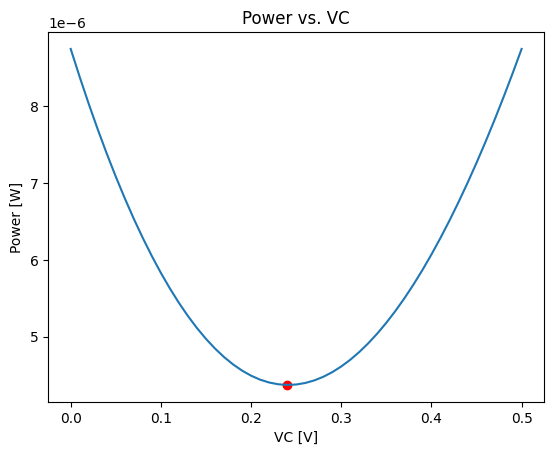

In [8]:
plt.plot(VC, p)
plt.scatter(VC[stationary_ind], p[stationary_ind], c='r')
plt.title('Power vs. VC')
plt.xlabel('VC [V]')
plt.ylabel('Power [W]')
plt.show()

In [248]:
VG1 = 2
VG2 = 2
clamp_sweep = np.arange(0, 5, 0.01)
source_vals = np.linspace(0, .5, 20)
# source_vals = np.linspace(min(VG1, VG2) + 0.7, 5, 20)

powers = []
source_powers = []

for VS in source_vals:
    circuit = f"""* /Users/lancemathias/Documents/LTspice/Draft11.asc
M1 N003 N005 N001 N001 NMOS
Vin N003 0 5
M2 N001 N006 P001 P001 NMOS
Vout P001 0 0
VC N001 0 0
VG1 N005 0 {VG1}
VG2 N006 0 {VG2}
.model NMOS NMOS
.model PMOS PMOS
.lib /Users/lancemathias/Library/Application Support/LTspice/lib/cmp/standard.mos
.dc VC {clamp_sweep.min()} {clamp_sweep.max()} {np.diff(clamp_sweep)[0]}
"""
    with open('test.cir', 'w') as f:
        f.write(circuit)
    os.system('/Applications/LTspice.app/Contents/MacOS/LTspice -b test.cir test.cir -o test.raw')

    l = ltspice.Ltspice(f'test.raw')
    l.parse()

    p = l.get_data('V(N003,N001)')*l.get_data('Id(M1)') + l.get_data('V(N001,P001)')*l.get_data('Id(M2)')
    sp = -l.get_data('V(N001)')*l.get_data('I(VC)')
    powers.append(p)
    source_powers.append(sp)

In [249]:
VG1 = 2
VG2 = 2
vg_sweep = np.arange(1, 6, 1)
source_vals = np.arange(0, 5, 0.01)

free_states = []

for vg in vg_sweep:
    circuit_2 = f"""* /Users/lancemathias/Documents/LTspice/Draft11.asc
M1 N003 N005 N001 N001 NMOS
Vin N003 0 5
M2 N001 N006 P001 P001 NMOS
Vout P001 0 0
VG1 N005 0 {vg}
VG2 N006 0 {vg}
.model NMOS NMOS
.model PMOS PMOS
.lib /Users/lancemathias/Library/Application Support/LTspice/lib/cmp/standard.mos
.dc Vin {source_vals.min()} {source_vals.max()} {np.diff(source_vals)[0]}
.backanno
.end
"""
    with open('test.cir', 'w') as f:
        f.write(circuit_2)
    os.system('/Applications/LTspice.app/Contents/MacOS/LTspice -b test.cir test.cir -o test.raw')

    l = ltspice.Ltspice(f'test.raw')
    l.parse()

    free_states.append(l.get_data('V(N001)'))

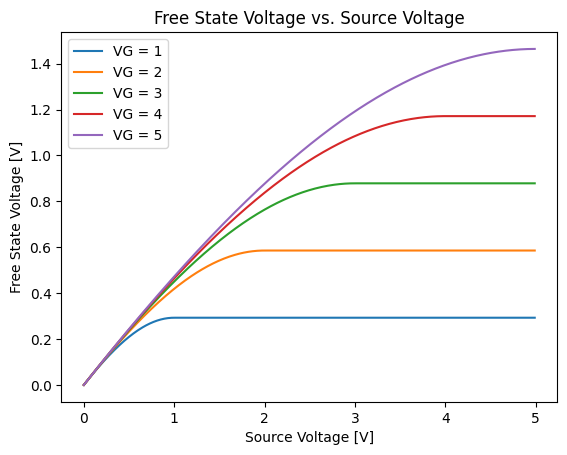

In [250]:
for i in range(len(free_states)):
    plt.plot(source_vals, free_states[i], label=f'VG = {vg_sweep[i]}')
plt.legend()
plt.title('Free State Voltage vs. Source Voltage')
plt.xlabel('Source Voltage [V]')
plt.ylabel('Free State Voltage [V]')
plt.show()

In [240]:
VG1 = 5
VG2 = 5
clamp_sweep = np.arange(0, 1, 0.001)
source_vals = np.linspace(0.2, 1, 5)

powers = []
source_powers = []
free_states = []
free_powers = []

for VS in source_vals:
    circuit = f"""* /Users/lancemathias/Documents/LTspice/Draft11.asc
M1 N003 N005 N001 N001 NMOS
Vin N003 0 {VS}
M2 N001 N006 P001 P001 NMOS
Vout P001 0 0
VC N001 0 0
* Ground-referenced VG
* VG1 N005 0 {VG1}
* VG2 N006 0 {VG2}
* Source-referenced VG
VG1 N005 N001 {VG1}
VG2 N006 P001 {VG2}
.model NMOS NMOS
.model PMOS PMOS
.lib /Users/lancemathias/Library/Application Support/LTspice/lib/cmp/standard.mos
.dc VC {clamp_sweep.min()} {clamp_sweep.max()} {np.diff(clamp_sweep)[0]}
"""
    with open('test.cir', 'w') as f:
        f.write(circuit)
    os.system('/Applications/LTspice.app/Contents/MacOS/LTspice -b test.cir test.cir -o test.raw')

    l = ltspice.Ltspice(f'test.raw')
    l.parse()

    p = l.get_data('V(N003,N001)')*l.get_data('Id(M1)') + l.get_data('V(N001,P001)')*l.get_data('Id(M2)')
    sp = -l.get_data('V(N001)')*l.get_data('I(VC)')
    powers.append(p)
    source_powers.append(sp)

    circuit_2 = f"""* /Users/lancemathias/Documents/LTspice/Draft11.asc
M1 N003 N005 N001 N001 NMOS
Vin N003 0 {VS}
M2 N001 N006 P001 P001 NMOS
Vout P001 0 0
* Ground-referenced VG
* VG1 N005 0 {VG1}
* VG2 N006 0 {VG2}
* Source-referenced VG
VG1 N005 N001 {VG1}
VG2 N006 P001 {VG2}
.model NMOS NMOS
.model PMOS PMOS
.lib /Users/lancemathias/Library/Application Support/LTspice/lib/cmp/standard.mos
.op
.backanno
.end
"""
    with open('test.cir', 'w') as f:
        f.write(circuit_2)
    os.system('/Applications/LTspice.app/Contents/MacOS/LTspice -b test.cir test.cir -o test.raw')

    l = ltspice.Ltspice(f'test.raw')
    l.parse()

    free_states.append(l.get_data('V(N001)'))
    free_powers.append(l.get_data('V(N003,N001)')*l.get_data('Id(M1)') + l.get_data('V(N001,P001)')*l.get_data('Id(M2)'))

In [241]:
dp = np.diff(powers, axis=1)
dp_source = np.diff(source_powers, axis=1)
stationary_inds = np.argmin(np.abs(dp), axis=1)
stationary_inds_source = np.argmin(np.abs(dp_source+dp), axis=1)

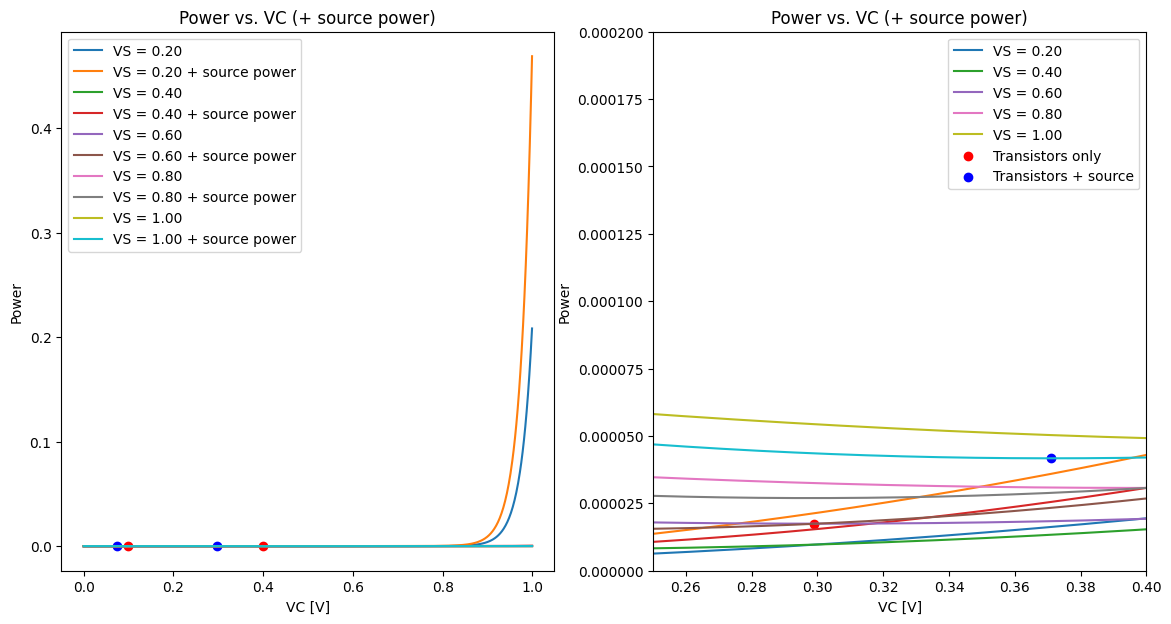

In [242]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
for i in range(0, len(powers), 1):
    plt.plot(clamp_sweep, powers[i], label=f'VS = {source_vals[i]:.2f}')
    plt.plot(clamp_sweep, powers[i]+source_powers[i], label=f'VS = {source_vals[i]:.2f} + source power')

plt.scatter(clamp_sweep[stationary_inds][0:len(powers):3], np.array(powers)[np.arange(len(powers)), stationary_inds][0:len(powers):3], c='r')
plt.scatter(clamp_sweep[stationary_inds_source][0:len(powers):3], np.array(powers)[np.arange(len(powers)), stationary_inds_source][0:len(powers):3], c='b')
plt.legend()
plt.title('Power vs. VC (+ source power)')
plt.xlabel('VC [V]')
plt.ylabel('Power')

plt.subplot(1, 2, 2)
for i in range(0, len(powers), 1):
    plt.plot(clamp_sweep, powers[i], label=f'VS = {source_vals[i]:.2f}')
    plt.plot(clamp_sweep, powers[i]+source_powers[i],)

plt.scatter(clamp_sweep[stationary_inds][0:len(powers):2], np.array(powers)[np.arange(len(powers)), stationary_inds][0:len(powers):2], c='r', label='Transistors only')
plt.scatter(clamp_sweep[stationary_inds_source][0:len(powers):2], (np.array(source_powers)+np.array(powers))[np.arange(len(powers)), stationary_inds_source][0:len(powers):2], c='b', label='Transistors + source')
plt.legend()
plt.title('Power vs. VC (+ source power)')
plt.xlabel('VC [V]')
plt.ylabel('Power')
plt.ylim([0, 2e-4])
plt.xlim([0.25, .4])
plt.show()

## New plots 12/20

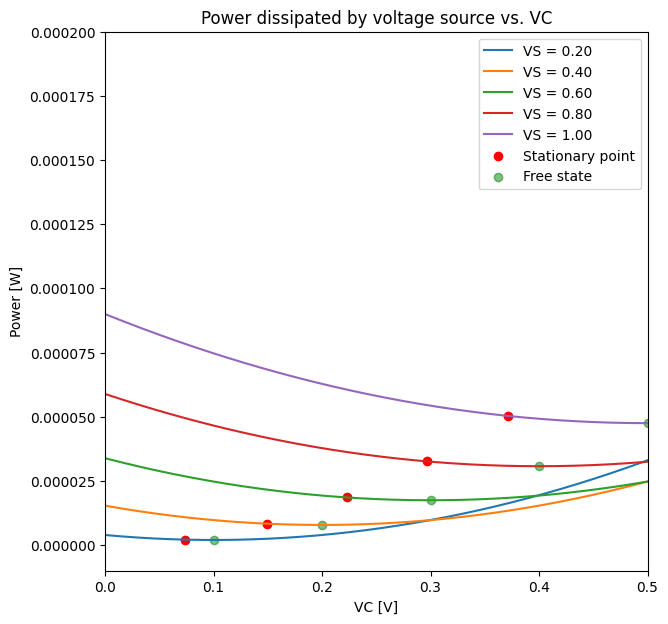

In [243]:
plt.figure(figsize=(7, 7))

# plt.subplot(1, 2, 1)
# for i in range(0, len(powers), 1):
#     plt.plot(clamp_sweep, source_powers[i], label=f'VS = {source_vals[i]:.2f}')

# plt.legend()
# plt.title('Power dissipated by voltage source vs. VC')
# plt.xlabel('VC [V]')
# plt.ylabel('Power [W]')

# plt.subplot(1, 2, 2)
for i in range(0, len(powers), 1):
    plt.plot(clamp_sweep, powers[i], label=f'VS = {source_vals[i]:.2f}')


# j=2
# plt.scatter(clamp_sweep[stationary_inds_source][j], [source_powers[i][stationary_inds_source][i] for i in range(len(powers))][j], c='r', label='Stationary point')
# plt.scatter(free_states[j], free_powers[j], c='g', label='Free state')
plt.scatter(clamp_sweep[stationary_inds_source], [powers[i][stationary_inds_source][i] for i in range(len(powers))], c='r', label='Stationary point')
plt.scatter(free_states, free_powers, c='g', label='Free state', alpha=0.5)

plt.ylim(-1e-5, 2e-4) 
plt.xlim(0, .5)
plt.legend()
plt.title('Power dissipated by voltage source vs. VC')
plt.xlabel('VC [V]')
plt.ylabel('Power [W]')
plt.show()

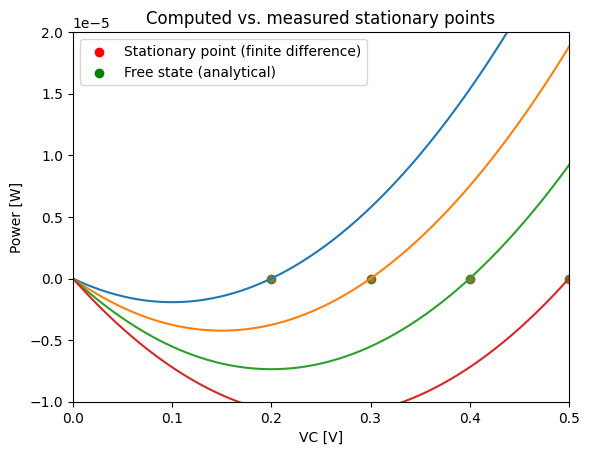

In [247]:
# verification that our free state voltages are correct
j = 3
plt.ylim(-1e-5, 2e-5)
plt.xlim(0, .5)
for j in range(1, 5):
    plt.plot(clamp_sweep, source_powers[j])
    source_zeros = np.argwhere(np.diff(np.sign(source_powers[j])))[1]+1
    plt.scatter(clamp_sweep[source_zeros], source_powers[j][source_zeros], c='r', alpha=0.5)
    plt.scatter(free_states[j], 0, c='g', alpha=0.5)

plt.scatter([], [], c='r', label='Stationary point (finite difference)')
plt.scatter([], [], c='g', label='Free state (analytical)')
plt.xlabel('VC [V]')
plt.ylabel('Power [W]')
plt.title('Computed vs. measured stationary points')
plt.legend()

## Old plots 12/13

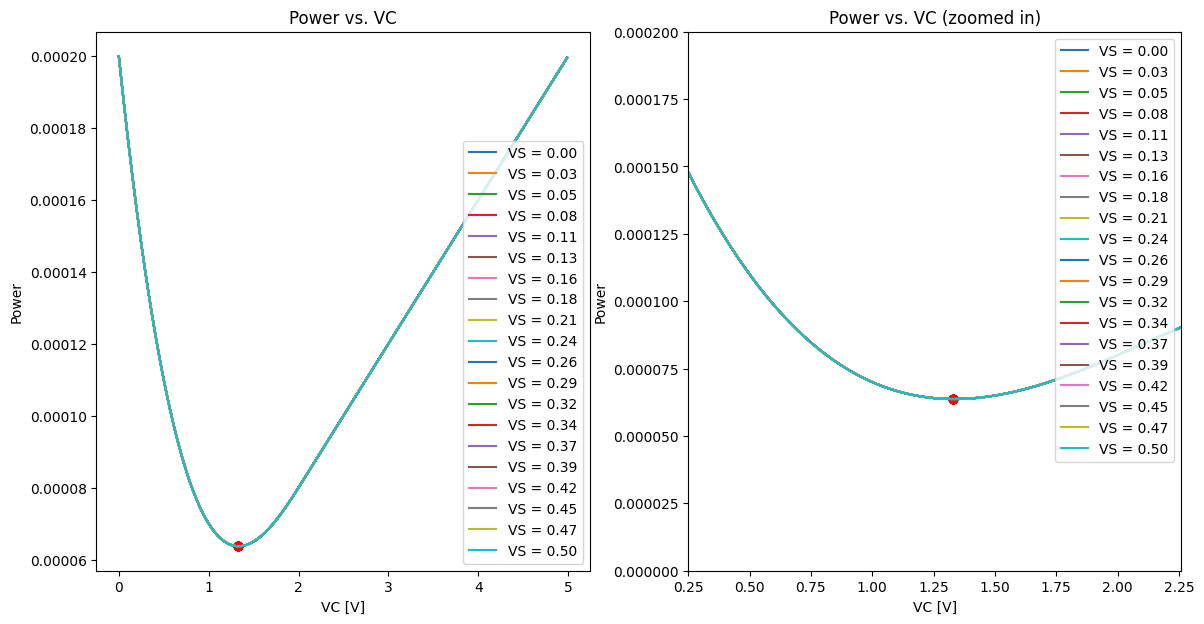

In [67]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
for i in range(len(powers)):
    plt.plot(clamp_sweep, powers[i], label=f'VS = {source_vals[i]:.2f}')

plt.scatter(clamp_sweep[stationary_inds], np.array(powers)[np.arange(len(powers)), stationary_inds], c='r')
plt.legend()
plt.title('Power vs. VC')
plt.xlabel('VC [V]')
plt.ylabel('Power')

plt.subplot(1, 2, 2)
for i in range(len(powers)):
    plt.plot(clamp_sweep, powers[i], label=f'VS = {source_vals[i]:.2f}')

plt.scatter(clamp_sweep[stationary_inds], np.array(powers)[np.arange(len(powers)), stationary_inds], c='r')
plt.legend()
plt.title('Power vs. VC (zoomed in)')
plt.xlabel('VC [V]')
plt.ylabel('Power')
plt.ylim([0, 2e-4])
plt.xlim([0.25, 2.26])
plt.show()

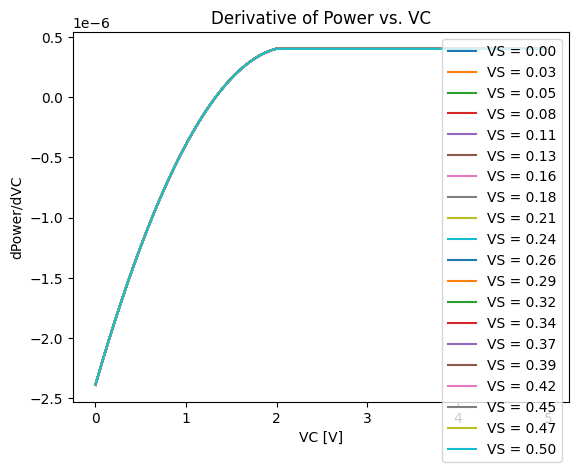

In [68]:
for i in range(len(powers)):
    plt.plot(clamp_sweep[:-1], dp[i], label=f'VS = {source_vals[i]:.2f}')
plt.legend()
plt.title('Derivative of Power vs. VC')
plt.xlabel('VC [V]')
plt.ylabel('dPower/dVC')
plt.show()

### Trying to wrangle ngspice

In [9]:
parser = SpiceParser(path='data/Draft11.net')
circuit = parser.build_circuit()

In [10]:
circuit.title = 'Draft11'

In [11]:
print(circuit)

.title Draft11
M1 N003 N005 N001 N001 NMOS
V1 N003 0 .5
VG N005 0 1
M2 N001 N005 P001 P001 NMOS
VC P001 0 0
V2 N001 0 0
.model NMOS NMOS ()
.model PMOS PMOS ()



In [25]:
simulator = circuit.simulator()

In [26]:
simulator.options(ngbehavior='lt')
simulator._options

{'TEMP': UnitValue(27 °C),
 'TNOM': UnitValue(27 °C),
 'NOINIT': None,
 'filetype': 'binary',
 'ngbehavior': 'lt'}

In [27]:
analysis = simulator.dc(V2=slice(0, 0.5, 0.01))

2023-12-15 04:44:54,286 - PySpice.Spice.NgSpice.Simulation.NgSpiceSubprocessCircuitSimulator - Simulation.DEBUG - desk
.title Draft11
M1 N003 N005 N001 N001 NMOS
V1 N003 0 .5
VG N005 0 1
M2 N001 N005 P001 P001 NMOS
VC P001 0 0
V2 N001 0 0
.model NMOS NMOS ()
.model PMOS PMOS ()
.options TEMP = 27C
.options TNOM = 27C
.options NOINIT
.options filetype = binary
.options ngbehavior = lt
.dc V2 0 0.5 0.01
.end

2023-12-15 04:44:54,287 - PySpice.Spice.NgSpice.Server.SpiceServer - Server.INFO - Start the spice subprocess


FileNotFoundError: [Errno 2] No such file or directory: 'ngspice setup.sp'